In [1]:
import torch
import os
import sys
import copy

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import wandb

In [5]:
epochs = 5

In [6]:
# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="dbr",
    
#     # track hyperparameters and run metadata
#     config={
#         "learning_rate": 0.02,
#         "architecture": "GAT",
#         "dataset": "CIFAR-100",
#         "epochs": 10,
#     }
# )

In [7]:
device = "cuda:0"

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [10]:
os.getcwd()

'/home/thomas/Work/Research/uil/dbr'

In [11]:
from src.graph_construction import graph
nycgraph, rebuild_info = graph(
    "new-york",
    neighbor_radius=10,
    building_buffer=30,
    test_percent=15
)

In [12]:
rebuild_info.keys()

dict_keys(['rebuild_idx', 'recorded', 'node_data', 'footprints', 'complete_footprints', 'training_mask', 'simple_ids'])

In [13]:
training_ids = np.array(rebuild_info["simple_ids"])[rebuild_info["training_mask"].cpu()]

In [14]:
true_idx = np.where(rebuild_info['training_mask'].cpu().numpy())[0]

In [15]:
validation_batches = []

np.random.seed(0)
for i in range(100):
    validation_batches.append(
        np.random.choice(true_idx, 100, replace=False)
    )

In [16]:
# now I want to build training and validation masks
cv_masks = []
true_base = rebuild_info['training_mask'].cpu().numpy()

for validation_idx in validation_batches:
    training_mask = copy.deepcopy(true_base)
    training_mask[validation_idx] = False
    
    validation_mask = np.repeat([False], len(true_base))
    validation_mask[validation_idx] = True
    
#     training_mask = []
#     validation_mask = []
    
#     for building_id in rebuild_info["simple_ids"]:
#         if (building_id in training_ids and building_id in cvbatch):
#             training_mask.append(False)
#             validation_mask.append(True)
#         elif (building_id in training_ids and building_id not in cvbatch):
#             training_mask.append(True)
#             validation_mask.append(False)
#         else:
#             training_mask.append(False)
#             validation_mask.append(False)
            
    cv_masks.append(
        (training_mask, validation_mask)
    )

In [17]:
cv_masks[0][1].sum()

100

In [18]:
sample_train, sample_val = cv_masks[0]

In [19]:
sample_val.sum()

100

In [20]:
training_ids.shape

(18106,)

In [21]:
rebuild_info["training_mask"]

tensor([ True,  True,  True,  ...,  True, False,  True], device='cuda:0')

In [22]:
rebuild_info["training_mask"].sum()

tensor(18106, device='cuda:0')

In [23]:
rebuild_info.keys()

dict_keys(['rebuild_idx', 'recorded', 'node_data', 'footprints', 'complete_footprints', 'training_mask', 'simple_ids'])

In [24]:
rebuild_info['rebuild_idx']

tensor([    0,     0,     0,  ..., 21298, 21298, 21299], device='cuda:0')

In [25]:
rebuild_info['recorded'].shape

torch.Size([45941])

In [26]:
data = nycgraph

In [27]:
nycgraph['footprint'].y

tensor([ 7.6797,  6.8100, 13.9315,  ...,  6.9140,  7.8968,  6.2182],
       device='cuda:0')

In [28]:
nycgraph['pano'].x.shape

torch.Size([52298, 6])

In [29]:
nycgraph['footprint'].train_mask.sum()

tensor(18106, device='cuda:0')

In [30]:
nycgraph['footprint'].x.shape[1]

6

In [31]:
from src.model import NullModel

input_shape = nycgraph['footprint'].x.shape[1]
nullmodel = NullModel(layers=2, input_channels = input_shape).to(device)

In [84]:
def reset_model(model):
    for layer in model.children():
       if hasattr(layer, 'reset_parameters'):
           layer.reset_parameters()
    return model

In [85]:
epochs = 500
loss_func = torch.nn.MSELoss()

rebuilding_idx = rebuild_info['rebuild_idx'].cpu().numpy()

In [86]:
data['footprint'].x.shape

torch.Size([21300, 6])

In [37]:
nullmodel(data['footprint'].x).shape

torch.Size([21300, 1])

In [42]:
# null learning system
null_training_losses = []
null_validation_losses = []

null_optimizer = torch.optim.Adam(nullmodel.parameters())

for c,masks in enumerate(cv_masks):
    nullmodel = reset_model(nullmodel)
#     print(f"Training fold: {c}")
    train_mask, val_mask = masks
    
    trainmask_ex = train_mask[rebuilding_idx]
    valmask_ex = val_mask[rebuilding_idx]
    
    np.random.seed(1)
#     print(f"Training idx sample: {np.random.choice(train_mask, 100).sum()}")
    fold_trainingloss = []
    fold_validationloss = []
    
    for epoch in range(epochs):
        loss = 0
        validation_loss = 0
        
        null_optimizer.zero_grad()
        out = nullmodel(data['footprint'].x)
        out_ex = out.squeeze()[rebuilding_idx]

        training_predictions = out_ex[trainmask_ex].to(torch.float)
        training_values = rebuild_info['recorded'][trainmask_ex].to(torch.float)

        validation_predictions = out_ex[valmask_ex].to(torch.float)      
        validation_values = rebuild_info['recorded'][valmask_ex].to(torch.float)

        loss = loss_func(
            training_predictions,
            training_values
        ).to(torch.float)
                
        fold_trainingloss.append(loss.detach().cpu().numpy())

#         if epoch % 50 == 0:
#             print(f"Loss at step: {epoch} is {loss}")
        with torch.no_grad():
            validation_loss = loss_func(
                validation_predictions,
                validation_values
            ).detach().cpu().numpy()
            fold_validationloss.append(validation_loss)
        
        loss.backward()
        null_optimizer.step()
            
#     print(f"Rebuild shape: {rebuilding_idx.shape}")
#     print(f"Training shape: {trainmask_ex.shape}")
#     print(f"Output shape: {out_ex.shape}")
#     print(validation_predictions.shape)
        
    null_training_losses.append(fold_trainingloss)
    null_validation_losses.append(fold_validationloss)
    
null_training_tensor = np.array(null_training_losses)
null_validation_tensor = np.array(null_validation_losses)

In [43]:
np.array(null_training_losses).shape

(100, 500)

In [45]:
rebuild_info['recorded'][trainmask_ex].mean()

tensor(7.5302, device='cuda:0', dtype=torch.float64)

In [46]:
rebuild_info['recorded'][valmask_ex].mean()

tensor(7.7837, device='cuda:0', dtype=torch.float64)

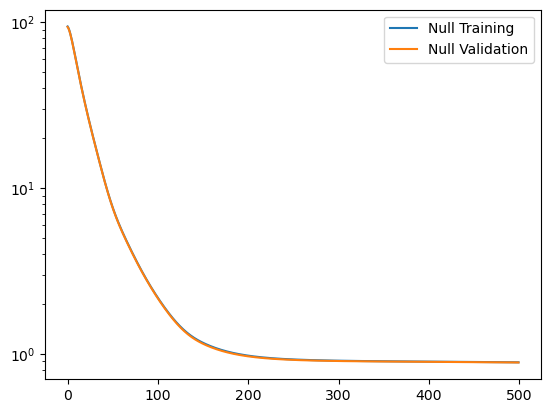

In [55]:
plt.plot(null_training_tensor.mean(axis=0), label="Null Training")
plt.plot(null_validation_tensor.mean(axis=0), label="Null Validation")
plt.legend()

plt.yscale("log")
plt.show()

In [127]:
from src.model import CustomGAT

model = CustomGAT(
    hidden_channels=32, 
    out_channels=32,
    layers=4,
    heads=5
).to(device)

model

CustomGAT(
  (convs): ModuleList(
    (0): GATConv((-1, -1), 32, heads=5)
    (1): GATConv((-1, -1), 32, heads=5)
    (2): GATConv((-1, -1), 32, heads=5)
    (3): GATConv((-1, -1), 32, heads=5)
  )
  (lins): ModuleList(
    (0): Linear(-1, 160, bias=True)
    (1): Linear(-1, 160, bias=True)
    (2): Linear(-1, 160, bias=True)
    (3): Linear(-1, 160, bias=True)
  )
  (conv_translate): HeteroConv(num_relations=1)
  (mlp): Sequential(
    (0): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
    (2): Linear(in_features=160, out_features=8, bias=True)
    (3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=8, out_features=8, bias=True)
    (6): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [128]:
# graph learning system
training_losses = []
validation_losses = []

optimizer = torch.optim.Adam(model.parameters())

for c,masks in enumerate(cv_masks):
    model = reset_model(model)
#     print(f"Training fold: {c}")
    train_mask, val_mask = masks
    
    trainmask_ex = train_mask[rebuilding_idx]
    valmask_ex = val_mask[rebuilding_idx]
    
    np.random.seed(1)
#     print(f"Training idx sample: {np.random.choice(train_mask, 100).sum()}")
    fold_trainingloss = []
    fold_validationloss = []
    
    for epoch in range(epochs):
        loss = 0
        validation_loss = 0
        
        optimizer.zero_grad()
        out = model(data.x_dict, data.edge_index_dict)
        out_ex = out.squeeze()[rebuilding_idx]

        training_predictions = out_ex[trainmask_ex].to(torch.float)
        training_values = rebuild_info['recorded'][trainmask_ex].to(torch.float)

        validation_predictions = out_ex[valmask_ex].to(torch.float)      
        validation_values = rebuild_info['recorded'][valmask_ex].to(torch.float)

        loss = loss_func(
            training_predictions,
            training_values
        ).to(torch.float)
                
        fold_trainingloss.append(loss.detach().cpu().numpy())

#         if epoch % 200 == 0:
#             print(f"Loss at step: {epoch} is {loss}")
        with torch.no_grad():
            validation_loss = loss_func(
                validation_predictions,
                validation_values
            ).to(torch.float)
            fold_validationloss.append(validation_loss.detach().cpu().numpy())
        
        loss.backward()
        optimizer.step()
            
#     print(f"Rebuild shape: {rebuilding_idx.shape}")
#     print(f"Training shape: {trainmask_ex.shape}")
#     print(f"Output shape: {out_ex.shape}")
#     print(validation_predictions.shape)
        
    training_losses.append(fold_trainingloss)
    validation_losses.append(fold_validationloss)
    
graph_training_loss = np.array(training_losses)
graph_validation_loss = np.array(validation_losses)

In [129]:
mean_tl = graph_training_loss.mean(axis=0)
std_tl = graph_training_loss.std(axis=0)

mean_vl = graph_validation_loss.mean(axis=0)
std_vl = graph_validation_loss.std(axis=0)

null_mean_vl = null_training_tensor.mean(axis=0)
null_mean_tl = null_validation_tensor.mean(axis=0)

domain = np.arange(0, len(mean_tl))

In [132]:
10**0

1

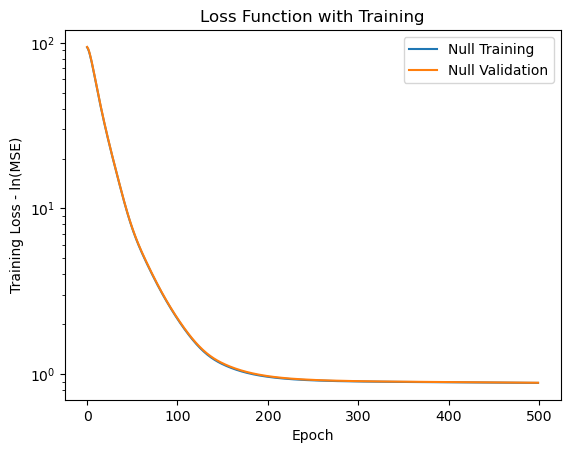

In [133]:
# plt.plot(domain, mean_tl, label="Train")
# # plt.fill_between(domain, mean_tl + std_tl, mean_tl - std_tl, alpha=0.1)

# plt.plot(domain, mean_vl, label="Validation")
# plt.fill_between(domain, mean_vl + std_vl, mean_vl - std_vl, alpha=0.1)

plt.plot(domain, null_mean_tl, label="Null Training")
plt.plot(domain, null_mean_vl, label="Null Validation")

plt.title("Loss Function with Training")

plt.xlabel("Epoch")
plt.ylabel("Training Loss - ln(MSE)")

plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
# plt.plot(domain, mean_tl, label="Train")
# plt.fill_between(domain, mean_tl + std_tl, mean_tl - std_tl, alpha=0.1)

plt.plot(domain, mean_vl, label="Validation")
# plt.fill_between(domain, mean_vl + std_vl, mean_vl - std_vl, alpha=0.1)

plt.plot(domain, null_mean_vl, label="Null Validation")
# plt.plot(domain, null_mean_tl, label="Null Training")

plt.title("Loss Function with Training")

plt.xlabel("Epoch")
plt.ylabel("Training Loss - MSE")
plt.legend()
plt.show()

In [ ]:
# param_size = 0
# for param in model.parameters():
#     param_size += param.nelement() * param.element_size()
# buffer_size = 0
# for buffer in model.buffers():
#     buffer_size += buffer.nelement() * buffer.element_size()

# size_all_mb = (param_size + buffer_size) / 1024**2
# print('model size: {:.3f}MB'.format(size_all_mb))

In [ ]:
nycgraph.x_dict['footprint'].shape

In [ ]:
output[rebuild_info['rebuild_idx']].flatten().shape

In [ ]:
rebuild_info['recorded'].shape

In [ ]:
output[]